## Group 4 - Final Project Part A
#### Michael Lindale, Taylor Sheridan, Matthew Rutigliano

### Data Preprocessing (Question 5, which we had to list at the top of our Jupyter Notebook File)
##### Defining functions from previous projects as well as different financial and portfolio variables that we'll reference in our code below

##### Markdown Version -

##### fastWindow = 5
##### slowWindow = 181
##### bbWindow = 20
##### stDevBand = 1
##### myStrategies = ['AAPL-MAFlat', 'EXC-BB', 'FBNDX-MAShort', 'GBP-BB', 'GE-MAShort', 'PFE-BB', 'SPGSCI-MAShort', 'SPY-MAFlat']


In [ ]:
##Question 5 - Code Version
fastwindow = 5
slowwindow = 181
bbwindow = 20
stdevband = 1
mystrategies = ['AAPL-MAFlat', 'EXC-BB', 'FBNDX-MAShort', 'GBP-BB', 'GE-MAShort', 'PFE-BB', 'SPGSCI-MAShort', 'SPY-MAFlat']

#### Importing in Packages and Functions

In [1]:
#Importing in Pandas, matplotlib ticker and pyplot, as well ScalarFormatter
import pandas as pd
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, PercentFormatter
import numpy as np
import matplotlib.ticker as mtick
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

aspect_ratio = (12,8) #For inline formatting of plots
af = 260

#### Previous Functions

In [2]:
#Function from HW1
def read_price_data(filename, index_col=0, parse_dates=True): #Paramaters in function
    df_sym = pd.read_csv(filename, index_col=index_col, parse_dates=parse_dates) #Reads in dataset
    print(df_sym.isnull().sum()) #Checks for null values
    print(df_sym.describe().round(2)) #Prints out Summary Statistics
    print(df_sym) #Prints the head and tail of the dataset
    return df_sym #Ends execution of function

#Function from HW3
def print_pct_data(df, format_spec = "{:.2%}", na_rep = "NaN", index_slice = None): #Paramaters in function
    pretty = df.style

    if index_slice is not None:
        #Apply formatting only to the specified subset using IndexSlice
        idx = pd.IndexSlice
        pretty = pretty.format(format_spec, subset=index_slice, na_rep=na_rep)
    else:
      percent_rows = ['Average Annual Return', 'Annual Risk', 'maxDD', 'Success Ratio', 'Weights']
      idx = pd.IndexSlice

    existing_rows = [row for row in percent_rows if row in df.index]
    if existing_rows:
      pretty = pretty.format(format_spec, subset=idx[existing_rows, :], na_rep = na_rep)
    else:
        #Apply formatting to the whole DataFrame
        pretty = pretty.format(format_spec, na_rep=na_rep)

    return pretty #Ends execution of function


def calcPerformanceStatistics(df, annualization_factor=260, print_Screen=True):
    #Calculate performance statistics
    performance_stats = pd.DataFrame([annualization_factor * df.mean(),
                                      np.sqrt(annualization_factor) * df.std(),
                                      df.mean() / df.std() * np.sqrt(annualization_factor),
                                      (df.cumsum().fillna(0) - np.maximum.accumulate(df.cumsum().fillna(0))).min(axis=0),
                                      (df >= 0).sum() / (df.shape[0] -1)],
                                      index=['Average Annual Return', 'Annual Risk', 'Sharpe Ratio', 'maxDD', 'Success Ratio'])

    #if print_Screen == True:
    #    from IPython.display import display  #Only needed in Jupyter/Notebook environments
    #    styled_df = print_pct_data(performance_stats)
    #    display(styled_df)
    #    return

    return performance_stats



def movingAverageCrossover(dataFrame, fastWindow, slowWindow): #Inputs of function
        if len(dataFrame.columns) > 1:
            raise ValueError("DataFrame should have only 1 column") #Function should only take a single instrument's prices
        else:
            securityName = dataFrame.columns[0] #defning object that retrieves security name
            dataFrame = dataFrame.rename(columns={securityName: 'symbol'}) #renames security name column to symbol
            dataFrame.loc[:,'FastSMA'] = dataFrame['symbol'].rolling(fastWindow).mean() #Defines fast moving average and assigns to new column
            dataFrame.loc[:,'SlowSMA'] = dataFrame['symbol'].rolling(slowWindow).mean() #Defines the slow moving average and assigns to new column
            dataFrame.dropna(inplace=True) #Drop missing values
            dataFrame.loc[:,'Position'] = np.where(dataFrame['FastSMA'] > dataFrame['SlowSMA'], 1, 0) #When FastMA is above SlowMA, marks position as 1 in a position column
            #dataFrame.style.format(na_rep='NaN')
            columnName1 = securityName+"-BMK-MA" #Calculates benchmark returns, assigning them to a new column (securityName + BMK-MA)
            dataFrame.loc[:,columnName1] = np.log(dataFrame['symbol'] / dataFrame['symbol'].shift(1)) #Previous Day's postiion, shifted by 1
            columnName2 = securityName+"-MAFlat" #Creates a new column of SecurityName + MAFlat
            dataFrame.loc[:,columnName2] = dataFrame['Position'].shift(1) * dataFrame[columnName1] #Multiplies benchmark returns by previous day's position


            dataFrameShort = dataFrame[['symbol', 'FastSMA', 'SlowSMA']].copy() # we have to create a copy because later we're going to add columns
            dataFrameShort.loc[:,'Position'] = np.where(dataFrameShort['FastSMA'] > dataFrameShort['SlowSMA'], 1, -1) #When FastMA is above SlowMA, marks position as 1 in a position column
            dataFrameShort.loc[:,columnName1] = np.log(dataFrame['symbol'] / dataFrame['symbol'].shift(1)) #Previous Day's postiion, shifted by 1
            columnName3 = securityName+"-MAShort" #Creates a new column of SecurityName + MAShort
            dataFrameShort.loc[:,columnName3] = dataFrameShort['Position'].shift(1) * dataFrameShort[columnName1] #Multiplies benchmark returns by previous day's position

            returnDataFrame = dataFrame[[columnName1, columnName2]].join(dataFrameShort[[columnName3]], how='inner') #Creates a new dataframe containing the benchmark returns, go flat returns and go short returns

            return returnDataFrame #returns the returnDataFrame



def bollingerBands(dataFrame, lookbackWindow, stDevBand): #Function inputs of dataframe of single instrument, a lookback window, and a stdevband
        if len(dataFrame.columns) > 1:
            raise ValueError("DataFrame should have only 1 column") #Dataframe should only have 1 instrument showing
        else:
            securityName = dataFrame.columns[0] #defning object that retrieves security name
            columnName1 = securityName + '-BMK-BB' #Creates column name for benchmark returns
            columnName2 = securityName + '-BB' #Creates column name for strategy returns
            dataFrame = dataFrame.rename(columns={securityName: 'symbol'}) #Renames security column to symbol
            dataFrame.loc[:,'Mean'] = dataFrame['symbol'].rolling(lookbackWindow).mean() #Calculates rolling mean using lookbackwindow
            dataFrame.loc[:,'Stdev'] = dataFrame['symbol'].rolling(lookbackWindow).std() #Calculates rolling stdev using lookbackwindow
            dataFrame.dropna(inplace=True) #Drop missing values
            dataFrame.loc[:,'Upper'] = dataFrame['Mean'] + stDevBand * dataFrame['Stdev'] #Calculates the upper band using the stdevband
            dataFrame.loc[:,'Lower'] = dataFrame['Mean'] - stDevBand * dataFrame['Stdev'] #Calculates the lower band using the stdevband

            date0 = dataFrame.index[0] #Check initial position, price on first day and sets initial postions
            if dataFrame.loc[date0,'symbol'] >= dataFrame.loc[date0, 'Upper']:
                dataFrame.loc[date0, 'Position'] = -1 #Set position to short
            elif dataFrame.loc[date0,'symbol'] <= dataFrame.loc[date0,'Lower']:
                dataFrame.loc[date0, 'Position'] = 1 #Set position to long
            else:
                dataFrame.loc[date0, 'Position'] = 0 #Set position to flat

            # then loop over the entire data set
            for i in range(1, dataFrame.shape[0]): #Loops through remaining days
                today=dataFrame.index[i]
                yesterday=dataFrame.index[i-1]
                if dataFrame.loc[today,'symbol'] >= dataFrame.loc[today,'Upper']: # if close is above upper. #Updates position based on - if price is above the upper band, go short
                    dataFrame.loc[today,'Position'] = -1 # then go short
                elif dataFrame.loc[today,'symbol'] <= dataFrame.loc[today,'Lower']: # if close is below lower. #Updates position based on - if price is below the lower band, go long
                    dataFrame.loc[today,'Position'] = 1 # then go long
                elif dataFrame.loc[yesterday,'Position'] == -1 and dataFrame.loc[today,'symbol'] <= dataFrame.loc[today,'Mean']: # if prev day is short and we're now below the mean
                    dataFrame.loc[today,'Position']=0 # then flatten
                elif dataFrame.loc[yesterday,'Position'] == 1 and dataFrame.loc[today, 'symbol'] >= dataFrame.loc[today, 'Mean']: # conversely...
                    dataFrame.loc[today,'Position']=0 # then also flatten
                else: # otherwise just hold yesterday's position
                    dataFrame.loc[today,'Position']=dataFrame.loc[yesterday,'Position']

            dataFrame.loc[:,columnName1] = np.log(dataFrame['symbol'] / dataFrame['symbol'].shift(1)) #Calculates daily logarithmic returns for benchmarking
            dataFrame.loc[:,columnName2] = dataFrame['Position'].shift(1) * dataFrame[columnName1] #Calculates strategy returns by multiplying the benchmark returns by previous day's position

            dataFrame = dataFrame.drop(['symbol', 'Mean', 'Stdev', 'Upper', 'Lower', 'Position'], axis=1) #Drops columns that aren't necessary for our datafram

            return dataFrame

### Question 1
#### Write a “wrapper” function, runMovingAverageAndBB, which will run the 2 technical trading strategy functions you wrote in Week 5 HW and then inner-join the results. This function takes 5 inputs: (a) a dataFrame with a single instrument’s prices (b) fastWindow (c) slowWindow (d) bbWindow and (e) stdevBand.

This function then simply calls the two Week 5 HW functions movingAverageCrossover and bollingerBands with the supplied input parameters and then returns a single dataFrame which is an inner-join of the outputs of the two functions. The output dataFrame should have 5 columns (and the -BMK-MA and -BMK-BB columns should be identical).

The main objective of this function is to inner-join the dates across the daily returns of the benchmark and the three strategies and present them in a single dataFrame. Be sure to .dropna() before returning the result.



In [5]:
def runMovingAverageAndBB(dataFrame, fastWindow, slowWindow, bbWindow, stDevBand): #definition of function
        if len(dataFrame.columns) > 1:
            raise ValueError("DataFrame should have only 1 column") #Dataframe should only have 1 instrument showing
        else:
            securityName = dataFrame.columns[0]
            resultsMA = movingAverageCrossover(dataFrame, fastWindow, slowWindow) #Moving average version
            resultsBB = bollingerBands(dataFrame, bbWindow, stDevBand) #Bollinger band version
            resultsCombined = resultsMA.join(resultsBB, how ='inner') #inner join of results
            resultsCombined = resultsCombined.dropna() #dropping missing values from combined
            return resultsCombined

### Question 2
##### Upload into Python the supplied data file PricesForProject.csv which contains (alphabetically arranged according to their ticker symbols) close price data from 12/31/1999 through 12/31/2018

#### Read in data file

In [6]:
prices = read_price_data('PricesForProject.csv') #Using read_price_data to calculate summary statistics
#Present heads and tails of each security price

AAPL      0
CAD       0
EXC       0
FBNDX     0
GBP       0
GE        0
INTC      0
PFE       0
SPGSCI    0
SPY       0
VBTIX     0
XPT       0
dtype: int64
          AAPL      CAD      EXC    FBNDX      GBP       GE     INTC      PFE  \
count  4780.00  4780.00  4780.00  4780.00  4780.00  4780.00  4780.00  4780.00   
mean     12.91     0.83    29.14     7.48     1.60   169.69    28.21    27.60   
std      13.98     0.12    10.49     0.38     0.20    61.02    10.65     7.62   
min       0.23     0.62    11.99     6.17     1.21    39.99    12.08    11.06   
25%       1.09     0.75    22.32     7.26     1.46   121.28    21.08    21.91   
50%       6.52     0.82    26.40     7.52     1.58   168.35    25.16    28.07   
75%      22.63     0.95    32.77     7.77     1.74   206.45    32.80    32.71   
max      58.02     1.09    65.36     8.06     2.11   360.30    74.88    46.49   

        SPGSCI      SPY    VBTIX      XPT  
count  4780.00  4780.00  4780.00  4780.00  
mean    435.61   150.58  

#### Question 3

##### Break out DataFrames for each instrument and construct a portfolio of those dataframes. The portfolio must use the instrument itself, or apply the MA crossover strategy (flat or short), or the Bollinger Band strategy.

In [ ]:
# Equity (Choose 5)
AAPL= pd.DataFrame(prices['AAPL'])
EXC= pd.DataFrame(prices['EXC'])
GE= pd.DataFrame(prices['GE'])
INTC= pd.DataFrame(prices['INTC'])
PFE= pd.DataFrame(prices['PFE'])
SPY= pd.DataFrame(prices['SPY'])

# Fixed Income (Choose 1)
FBNDX= pd.DataFrame(prices['FBNDX'])
VBTIX= pd.DataFrame(prices['VBTIX'])

# Commodity (Choose 1)
SPGSCI= pd.DataFrame(prices['SPGSCI'])
XPT= pd.DataFrame(prices['XPT'])

# Currency (Choose 1)
CAD= pd.DataFrame(prices['CAD'])
GBP= pd.DataFrame(prices['GBP'])

#### Choices in investment instruments that make up our portfolio must comply with the following constraints used in any of the strategies defined:
*   Constraint of 5 periods for the fast moving average
*   Sets window size for the slow moving average to 181 periods
*   Sets lookback window for the Bollinger Bands calculation to 20 periods
*   Sets 1 standard deviation for Bollinger Bands
*   Set annulization factor of 260 (for 260 training days in a years)


In [8]:
### Inputs that are used across strategies
global_fastWindow = 5 #all inputs should use the same fastwindow
global_slowWindow = 181   #180, all inputs use the same slowwindow
global_bbWindow = 20 # MUST BE >= 20 for a lookback window
global_stDevBand = 1 #Sets standard deviation for Bollinger Band
af=260 #Annualization factor

### Question 4
##### Spell out your choices of parameters and strategies in a Markdown cell.

##### List of parameters and strategies:
*   fastWindow = 5
*   slowWindow = 181
*   bbWindow = 20
*   stDevBand = 1
*   myStrategies = ['AAPL-MAFlat', 'EXC-BB', 'FBNDX-MAShort', 'GBP-BB', 'GE-MAShort',  'PFE-BB', 'SPGSCI-MAShort', 'SPY-MAFlat']

### Question 6

First, run your wrapper function runMovingAverageAndBB from #1 above on all 12 instruments (in alphabetical order) and using your chosen parameters.

You should have 12 dataframes with identical dates and 5 appropriately named columns each. Combine these 12 to create a “master” dataFrame with 60 columns. (The two “-BMK-MA” and the “-BMK-BB” columns should be identical.)

##### Defining the 12 dataframes using the wrapper function runMovingAverageAndBB in alphabetical order. Also include the parameters that we specified previously (fastWindow, slowWindow, bbWindow, stDevBand)

In [9]:
AAPLresults = runMovingAverageAndBB(AAPL, global_fastWindow, global_slowWindow, global_bbWindow, global_stDevBand)
CADresults = runMovingAverageAndBB(CAD, global_fastWindow, global_slowWindow, global_bbWindow, global_stDevBand)
EXCresults = runMovingAverageAndBB(EXC, global_fastWindow, global_slowWindow, global_bbWindow, global_stDevBand)
FBNDXresults = runMovingAverageAndBB(FBNDX, global_fastWindow, global_slowWindow, global_bbWindow, global_stDevBand)
GBPresults = runMovingAverageAndBB(GBP, global_fastWindow, global_slowWindow, global_bbWindow, global_stDevBand)
GEresults = runMovingAverageAndBB(GE, global_fastWindow, global_slowWindow, global_bbWindow, global_stDevBand)
INTCresults = runMovingAverageAndBB(INTC, global_fastWindow, global_slowWindow, global_bbWindow, global_stDevBand)
PFEresults = runMovingAverageAndBB(PFE, global_fastWindow, global_slowWindow, global_bbWindow, global_stDevBand)
SPGSCIresults = runMovingAverageAndBB(SPGSCI, global_fastWindow, global_slowWindow, global_bbWindow, global_stDevBand)
SPYresults = runMovingAverageAndBB(SPY, global_fastWindow, global_slowWindow, global_bbWindow, global_stDevBand)
VBTIXresults = runMovingAverageAndBB(VBTIX, global_fastWindow, global_slowWindow, global_bbWindow, global_stDevBand)
XPTresults = runMovingAverageAndBB(XPT, global_fastWindow, global_slowWindow, global_bbWindow, global_stDevBand)


##### Combining these 12 dataframes to create a master dataframe with 60 columns

In [13]:
allResults = AAPLresults.join(CADresults, how ='inner')
allResults = allResults.join(EXCresults, how ='inner')
allResults = allResults.join(FBNDXresults, how ='inner')
allResults = allResults.join(GBPresults, how ='inner')
allResults = allResults.join(GEresults, how ='inner')
allResults = allResults.join(INTCresults, how ='inner')
allResults = allResults.join(PFEresults, how ='inner')
allResults = allResults.join(SPGSCIresults, how ='inner')
allResults = allResults.join(SPYresults, how ='inner')
allResults = allResults.join(VBTIXresults, how ='inner')
allResults = allResults.join(XPTresults, how ='inner')
display(allResults) #print out an example of what our master dataframe will look like

,AAPL-BMK-MA,AAPL-MAFlat,AAPL-MAShort,AAPL-BMK-BB,AAPL-BB,CAD-BMK-MA,CAD-MAFlat,CAD-MAShort,CAD-BMK-BB,CAD-BB,...,VBTIX-BMK-MA,VBTIX-MAFlat,VBTIX-MAShort,VBTIX-BMK-BB,VBTIX-BB,XPT-BMK-MA,XPT-MAFlat,XPT-MAShort,XPT-BMK-BB,XPT-BB
Date,,,,,,,,,,,,,,,,,,,,,
2000-09-19,-0.011920,-0.011920,-0.011920,-0.011920,-0.000000,0.003567,0.0,-0.003567,0.003567,0.003567,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.001347,-0.001347,-0.001347,-0.001347,-0.000000
2000-09-20,0.018339,0.018339,0.018339,0.018339,0.000000,-0.001078,-0.0,0.001078,-0.001078,-0.001078,...,-0.001031,-0.001031,-0.001031,-0.001031,-0.000000,-0.001180,-0.001180,-0.001180,-0.001180,-0.000000
2000-09-21,-0.074088,-0.074088,-0.074088,-0.074088,-0.000000,-0.001548,-0.0,0.001548,-0.001548,-0.001548,...,0.001031,0.001031,0.001031,0.001031,0.001031,-0.015293,-0.015293,-0.015293,-0.015293,-0.000000
2000-09-22,-0.082711,-0.082711,-0.082711,-0.082711,-0.082711,-0.000807,-0.0,0.000807,-0.000807,-0.000807,...,0.002060,0.002060,0.002060,0.002060,0.002060,0.005124,0.005124,0.005124,0.005124,0.005124
2000-09-25,0.024838,0.024838,0.024838,0.024838,0.024838,0.001816,0.0,-0.001816,0.001816,0.001816,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.006838,-0.006838,-0.006838,-0.006838,-0.006838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,-0.026215,-0.000000,0.026215,-0.026215,-0.026215,0.000368,0.0,-0.000368,0.000368,0.000368,...,0.001919,0.001919,0.001919,0.001919,-0.001919,-0.001678,-0.000000,0.001678,-0.001678,-0.001678
2018-12-26,0.068053,0.000000,-0.068053,0.068053,0.068053,0.001693,0.0,-0.001693,0.001693,0.001693,...,-0.003842,-0.003842,-0.003842,-0.003842,0.003842,0.014666,0.000000,-0.014666,0.014666,0.014666
2018-12-27,-0.006511,-0.000000,0.006511,-0.006511,-0.006511,-0.003310,-0.0,0.003310,-0.003310,-0.003310,...,0.000962,0.000962,0.000962,0.000962,-0.000962,-0.000941,-0.000000,0.000941,-0.000941,-0.000941


### Question 7

##### Explain your rationale for your choices.

The aim is to have as high a Sharpe as possible for your final portfolio, and it should be no less than 1.0. You can generally achieve that by choosing high-Sharpe components of your portfolio but also by combining strategies that are not highly correlated. Sometimes, a low-Sharpe strategy may improve the overall portfolio Sharpe because of its low correlation with other instruments (the diversification benefit).

With the instruments at hand, all equities will likely be highly correlated (although the correlations could potentially drop after application of one of the technical strategies), but the non-equity instruments may exhibit low, or even negative correlations.

Please bear in mind that there is no right answer here. I am not looking for a “super-optimized” portfolio; what I’d like to see is your reasoning for what you pick.

Answer - The five equity instruments were based on their Sharpe Ratios. These five represent the five highest Sharpe Ratios for each respective instrument.

INTC was left out, as the highest Sharpe Ratio for any strategy involving their instrument was 0.19 (0.1 less than our lowest equity Sharpe).

While we were originally going to choose the CAD-MAShort for our currency instrument, further analysis on the correlation indices vs our other instruments guided us towards the GBP-BB, which has a lower Sharpe Ratio alone, but provides a larger portfolio Sharpe ratio due to the lower correlation than the CAD-MAShort.

FBNDX-MAShort was chosen as our fixed income security for it's superior Sharpe ratio, with the same reasoning behind SPGSCI-MAShort for our commodity instrument.

### Question 8

##### Index-slice your master dataFrame from question six above using your chosen myStrategies variable from 5(e) above to create your “myStrategiesDF” dataframe which has the daily returns of just your 8 chosen strategies in alphabetical order (irrespective of asset class).

In [14]:
myStrategiesDF = allResults[['AAPL-MAFlat', 'EXC-BB', 'FBNDX-MAShort', 'GBP-BB', 'GE-MAShort',  'PFE-BB', 'SPGSCI-MAShort', 'SPY-MAFlat']].copy()
myStrategiesDF #print out index slice

,AAPL-MAFlat,EXC-BB,FBNDX-MAShort,GBP-BB,GE-MAShort,PFE-BB,SPGSCI-MAShort,SPY-MAFlat
Date,,,,,,,,
2000-09-19,-0.011920,0.040912,0.000000,0.001989,-0.008734,-0.000000,-0.010051,0.009032
2000-09-20,0.018339,0.015927,-0.001436,0.000993,-0.006601,-0.000000,0.000713,-0.007413
2000-09-21,-0.074088,0.001147,0.001436,0.018961,-0.006645,0.000000,-0.015811,-0.015322
2000-09-22,-0.082711,-0.029414,0.001434,0.000000,0.018713,0.000000,-0.022374,0.000000
2000-09-25,0.024838,0.007834,0.000000,-0.000000,0.013001,0.004240,-0.012281,-0.000000
...,...,...,...,...,...,...,...,...
2018-12-24,-0.000000,-0.000000,0.001303,0.004812,0.032697,-0.033466,0.034847,-0.000000
2018-12-26,0.000000,0.014721,-0.003914,-0.000000,-0.065712,0.039647,-0.034605,0.000000
2018-12-27,-0.000000,0.006722,-0.002618,0.000000,0.016371,0.015522,0.016042,0.000000


### Question 9
##### Correlation structure: Calculate the correlation matrix of the myStrategiesDF dataframe you created in question eight and comment on the correlation structure.

In [15]:
myStrategiesDF.corr() #print out correlation matrix from myStrategiesDF dataframe

,AAPL-MAFlat,EXC-BB,FBNDX-MAShort,GBP-BB,GE-MAShort,PFE-BB,SPGSCI-MAShort,SPY-MAFlat
AAPL-MAFlat,1.000000,0.007911,-0.004589,-0.008377,-0.035154,-0.000766,0.026557,0.364015
EXC-BB,0.007911,1.000000,-0.048600,0.064463,-0.064602,0.160721,-0.023796,-0.020369
FBNDX-MAShort,-0.004589,-0.048600,1.000000,-0.022377,0.017848,-0.012115,-0.039670,-0.078096
GBP-BB,-0.008377,0.064463,-0.022377,1.000000,-0.027136,0.070906,-0.077921,-0.018872
GE-MAShort,-0.035154,-0.064602,0.017848,-0.027136,1.000000,-0.139238,0.104013,0.126394
PFE-BB,-0.000766,0.160721,-0.012115,0.070906,-0.139238,1.000000,-0.064308,0.007057
SPGSCI-MAShort,0.026557,-0.023796,-0.039670,-0.077921,0.104013,-0.064308,1.000000,0.087006
SPY-MAFlat,0.364015,-0.020369,-0.078096,-0.018872,0.126394,0.007057,0.087006,1.000000


Answer: The portfolio instruments were chosen based on low correlation, to reduce risk. The highest correlation is 0.36, while most others are below 0.05 absolute value.

### Question 10
##### Weights: The next step is to determine the instrument weighting scheme. The simple case is equal weights.

Using the Matrix formulation for portfolio return and risk, calculate the annualized Sharpe of an equal-weighted portfolio of your chosen 8 strategies. Does the equal-weight portfolio outperform every individual strategy?

You get 2 extra credit points if you implement this Sharpe calculation with a single line of code by simply applying a bunch of methods to your myStrategiesDF dataFrame.

In [16]:
portfolio = myStrategiesDF.copy() #Assign our dataframe to the portfolio object
portfolio['Portfolio_Return'] = portfolio.mean(axis=1)
portfolioPerformance = calcPerformanceStatistics(portfolio) #Calculate portfolio statistics
print_pct_data(portfolioPerformance) #Print performance statistics

,AAPL-MAFlat,EXC-BB,FBNDX-MAShort,GBP-BB,GE-MAShort,PFE-BB,SPGSCI-MAShort,SPY-MAFlat,Portfolio_Return
Average Annual Return,25.85%,11.63%,1.89%,0.42%,9.24%,7.73%,11.16%,5.06%,9.12%
Annual Risk,27.99%,22.99%,3.79%,8.52%,31.10%,22.03%,23.62%,10.32%,7.65%
Sharpe Ratio,0.923509,0.506120,0.499048,0.049697,0.297257,0.351087,0.472415,0.490340,1.193144
maxDD,-63.00%,-58.33%,-8.36%,-33.37%,-102.54%,-40.67%,-57.72%,-18.54%,-10.13%
Success Ratio,66.18%,62.42%,64.33%,61.16%,51.37%,61.96%,51.78%,69.92%,53.72%


Answer: Yes, our equal weighted portfolio outperforms each of the individual underlying instruments, as indicated by the sharpe ratio that's greater than 1 (approximately 1.19) which is higher than any of the underlying instruments. The portfolio provides a positive risk-adjusted return.

### Question 11
##### MVO: To see if you can do better than equal weights, run a Mean-Variance optimization with your chosen strategies in order to determine the optimal weights.

This step will be identical to the efficient frontier generation you did in Week 4 HW. Use a 5,000-step Monte Carlo simulation with a seed of 64. Be sure to use the alphabetically ordered instruments.

Assemble all the different weight vectors so that you can later identify the weights of the minimum-vol and the maximum-Sharpe portfolios.

In [18]:
rng = np.random.default_rng(seed=64) #Random generator in numpy to generate a default range with a seed of 64
trials = 5000 #Number of trials that we want to generate

weights = np.zeros((trials,len(myStrategiesDF.columns))) #Stores portfolio weights for each trial of the simulation, each column represents a different asset
annualReturn = np.zeros(trials) #Stores the calculated annual return for each trial of the simulation
annualRisk = np.zeros(trials) #Stores the calculated annual risk for each trial of the simulation
sharpeRatio = np.zeros(trials) #Stores the calculated Sharpe ratio for each trial of the simulation

for i in range(trials): #Set up for loop for Monte Carlo Simulation
    wts = rng.random(len(myStrategiesDF.columns)) #Using the shape of the return matrix
    wts /= np.sum(wts) #Normalizes weight
    weights[i,:] = wts #Stores normalized weights in weights array

    weightedLogReturn = pd.DataFrame((wts * myStrategiesDF).sum(axis=1, skipna=False), columns=['Weighted']) #Calculates the daily return

    annualReturn[i] = af*weightedLogReturn.mean() #Annual Return matrix calculation
    annualRisk[i] = np.sqrt(af)*weightedLogReturn.std() #Annual Risk matrix calculation
    sharpeRatio[i] = weightedLogReturn.mean() / weightedLogReturn.std() * np.sqrt(af) #Sharpe Ratio matrix calculation

### Questions 12 - 14

##### 12. Plot the risk/return scatter plot of all the 5,000 portfolios, ensuring that the axes are formatted correctly as percentages. Include a colorbar based on the Sharpe ratio, and use the reverse colormap as in Week 4 HW.

##### 13. Mark the minimum vol portfolio with a blue star. Present the weights of this portfolio and rationalize the weight vector, i.e., give a plausible explanation for that outcome of weights. Construct a legend for the star, and include in the legend the x-value (risk), y-value (return) and the Sharpe ratio.

##### 14. Mark the maximum Sharpe portfolio with a red star. Present the weights of this portfolio and rationalize the weight vector. Construct a legend for the star, and include in the legend the x-value (risk), y-value (return) and the Sharpe ratio.


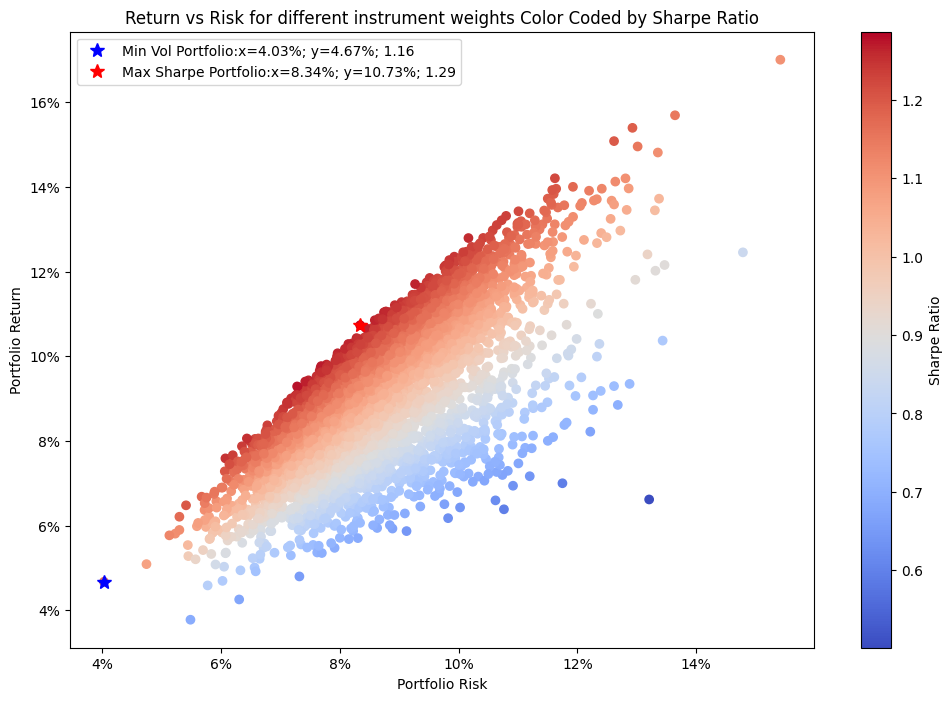

In [19]:
plt.figure(figsize=aspect_ratio) #Set aspect ratio to the one defined during preprocessing
ax = plt.subplot() #Creates a plotting area within the figure
plt.scatter(annualRisk, annualReturn, c = annualReturn/annualRisk, marker='o', cmap='coolwarm') #annualreturn/annual risk gives the Sharpe of each point
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0)) #Formats X-axis as a percentage
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0)) #Formats Y-axis as a percentage
plt.title('Return vs Risk for different instrument weights Color Coded by Sharpe Ratio') #Plot title
plt.xlabel('Portfolio Risk') #X-axis title
plt.ylabel('Portfolio Return')#Y-axis title
plt.colorbar(label='Sharpe Ratio') #Adds color bar using reverse colormap, then specify how we're going to plot our data and how we'll label the data
plt.plot(annualRisk[np.argmin(annualRisk)], annualReturn[np.argmin(annualRisk)], 'b*', markersize=10.0, label='Min Vol Portfolio:x={:.2%}; y={:.2%}; {:1.2f}'.format(annualRisk[np.argmin(annualRisk)], annualReturn[np.argmin(annualRisk)], annualReturn[np.argmin(annualRisk)]/annualRisk[np.argmin(annualRisk)]))
plt.plot(annualRisk[np.argmax(annualReturn/annualRisk)], annualReturn[np.argmax(annualReturn/annualRisk)], 'r*', markersize=10.0, label='Max Sharpe Portfolio:x={:.2%}; y={:.2%}; {:1.2f}'.format(annualRisk[np.argmax(annualReturn/annualRisk)], annualReturn[np.argmax(annualReturn/annualRisk)], np.max(annualReturn/annualRisk)))
plt.legend() #Adds legend based on min vol portfolio location and max sharpe portfolio location

##### Weights of Min Volatility Portfolio

In [23]:
a = calcPerformanceStatistics(myStrategiesDF) #using mystrategies dataframe
a.loc['Weights'] = weights[annualRisk.argmin()] #calculating weights of minimum volatility
print_pct_data(a) #print out data

,AAPL-MAFlat,EXC-BB,FBNDX-MAShort,GBP-BB,GE-MAShort,PFE-BB,SPGSCI-MAShort,SPY-MAFlat
Average Annual Return,25.85%,11.63%,1.89%,0.42%,9.24%,7.73%,11.16%,5.06%
Annual Risk,27.99%,22.99%,3.79%,8.52%,31.10%,22.03%,23.62%,10.32%
Sharpe Ratio,0.923509,0.506120,0.499048,0.049697,0.297257,0.351087,0.472415,0.490340
maxDD,-63.00%,-58.33%,-8.36%,-33.37%,-102.54%,-40.67%,-57.72%,-18.54%
Success Ratio,66.18%,62.42%,64.33%,61.16%,51.37%,61.96%,51.78%,69.92%
Weights,2.84%,8.93%,46.11%,13.68%,0.90%,4.85%,5.98%,16.72%


This portfolio places higher weights on those instruments that have a lower annual risk than others. The highest weighted instrument (FBNDX-MAShort) is almost 50% of the portfolio, and has by far the lowest annual risk.

##### Weights of Max Sharpe Portfolio

In [24]:
b = calcPerformanceStatistics(myStrategiesDF) #using mystrategies dataframe
b.loc['Weights'] = weights[sharpeRatio.argmax()] #calculating weights of the max sharpe portfolio
print_pct_data(b) #print out data

,AAPL-MAFlat,EXC-BB,FBNDX-MAShort,GBP-BB,GE-MAShort,PFE-BB,SPGSCI-MAShort,SPY-MAFlat
Average Annual Return,25.85%,11.63%,1.89%,0.42%,9.24%,7.73%,11.16%,5.06%
Annual Risk,27.99%,22.99%,3.79%,8.52%,31.10%,22.03%,23.62%,10.32%
Sharpe Ratio,0.923509,0.506120,0.499048,0.049697,0.297257,0.351087,0.472415,0.490340
maxDD,-63.00%,-58.33%,-8.36%,-33.37%,-102.54%,-40.67%,-57.72%,-18.54%
Success Ratio,66.18%,62.42%,64.33%,61.16%,51.37%,61.96%,51.78%,69.92%
Weights,20.82%,13.43%,26.95%,1.34%,7.85%,15.30%,10.52%,3.79%


This porfolio reduces the weighting on lower risk instruments that we saw above, and weights more prevalently towards instruments with higher Sharpe ratios. The highest Sharpe ratio instrument (AAPL-MAFlat) went from a weight of 2.8% of the portfolio to 20.8% when specifying for the max sharpe.

### Question 15
##### Is the maximum Sharpe higher than the equal weight Sharpe from #10 above?

Answer: Yes. The Sharpe ratio increases from 1.193 in the equally-weighted portfolio to 1.287 in the optimally weighted portfolio.

### Question 16
##### To the myStrategiesDF dataFrame you created in question eight, add a ninth column of daily returns which represent the maximum Sharpe portfolio (i.e., it’s the weighted returns using the maximum Sharpe weights).

Now display the performance statistics of this dataframe and explain the salient features of this table, i.e., how the final portfolio performance compares with the individual components. (Don’t forget to look at the maxDD improvement).

In [26]:
myStrategiesDF_weighted = myStrategiesDF.copy() #Copy of the original dataframe
#Adds a new column named Portoflio Return Weighted, containing daily returns of the weighted portfolio
##Multiplying daily returns by weight and then summing across
myStrategiesDF_weighted['Portfolio_Return_Weighted'] = myStrategiesDF_weighted.iloc[:, 0]*b.iloc[5, 0]+myStrategiesDF_weighted.iloc[:, 1]*b.iloc[5, 1]+myStrategiesDF_weighted.iloc[:, 2]*b.iloc[5, 2]+myStrategiesDF_weighted.iloc[:, 3]*b.iloc[5, 3]+myStrategiesDF_weighted.iloc[:, 4]*b.iloc[5, 4]+myStrategiesDF_weighted.iloc[:, 5]*b.iloc[5, 5]+myStrategiesDF_weighted.iloc[:, 6]*b.iloc[5, 6]+myStrategiesDF_weighted.iloc[:, 7]*b.iloc[5, 7]
print_pct_data(calcPerformanceStatistics(myStrategiesDF_weighted)) #Prints the performance statistics fo the myStrategiesDF dataframe

,AAPL-MAFlat,EXC-BB,FBNDX-MAShort,GBP-BB,GE-MAShort,PFE-BB,SPGSCI-MAShort,SPY-MAFlat,Portfolio_Return_Weighted
Average Annual Return,25.85%,11.63%,1.89%,0.42%,9.24%,7.73%,11.16%,5.06%,10.73%
Annual Risk,27.99%,22.99%,3.79%,8.52%,31.10%,22.03%,23.62%,10.32%,8.34%
Sharpe Ratio,0.923509,0.506120,0.499048,0.049697,0.297257,0.351087,0.472415,0.490340,1.287025
maxDD,-63.00%,-58.33%,-8.36%,-33.37%,-102.54%,-40.67%,-57.72%,-18.54%,-12.18%
Success Ratio,66.18%,62.42%,64.33%,61.16%,51.37%,61.96%,51.78%,69.92%,52.81%


Answer: Our portfolio has higher returns than all but 3 of the individual components, and less risk than all but one. This is leading to a much larger Sharpe Ratio than any component by over 35 percentage points (when compared to the next highest Sharpe Ratio).

It has a maxDD that is lower than all but 1 component, driven by the use of non-correlated instruments to limit the negative returns that any one component may drive.

### Question 17
##### Beta: Calculate the beta of your maximum Sharpe portfolio to the S&P 500. (Use the SPY-BMK-MA column from your master dataframe from #6 above.) Is it <= +0.5, as one of the constraints specifies? What does your beta value imply?

In [27]:
X = allResults['SPY-BMK-MA'] #Extracts daily returns from column
X = sm.add_constant(X) #Adds a cpmstamt term to the X variable
y = pd.DataFrame(myStrategiesDF_weighted['Portfolio_Return_Weighted']) #Extracts the daily returns of the maximum Sharpe portfolio

portfolio_Reg = sm.OLS(y, X) #Creates an OLS model object
portfolio_Reg = portfolio_Reg.fit() #Fits OLS model to the data
portfolio_Reg.params #Accesses estimated parameters of the regression model, contains the constant (intecept) and the coefficient for the column
#the coefficient is the estimated Beta of our portfolio compared to the S&P 500 (the general market)

,0
const,0.000401
SPY-BMK-MA,0.097992


Answer: Yes, the Beta is 0.097992. This indicates that there is significantly less risk with our portfolio than the general market. It implies that the price swings are generally about 10% of the swings seen in the market.

### Question 18
##### Construct 4 variations of the equal weighted portfolio as follows:

##### A. All benchmarks from your master dataFrame from #6 above, i.e, just the base instruments themselves, without either technical strategy. Note down the Sharpe of this BMK-only portfolio.

In [32]:
q18a = allResults[['SPY-BMK-MA', 'AAPL-BMK-MA', 'EXC-BMK-MA', 'GE-BMK-MA', 'INTC-BMK-MA', 'PFE-BMK-MA', 'GBP-BMK-MA', 'CAD-BMK-MA', 'FBNDX-BMK-MA', 'VBTIX-BMK-MA', 'SPGSCI-BMK-MA', 'XPT-BMK-MA']] #BMK Only
q18a = q18a.copy()
q18a['Portfolio_Return'] = q18a.mean(axis=1) #Adding on the portfolio return column
q18aPerformance = calcPerformanceStatistics(q18a) #Calculate performance stats
print_pct_data(q18aPerformance) #Print out stats

,SPY-BMK-MA,AAPL-BMK-MA,EXC-BMK-MA,GE-BMK-MA,INTC-BMK-MA,PFE-BMK-MA,GBP-BMK-MA,CAD-BMK-MA,FBNDX-BMK-MA,VBTIX-BMK-MA,SPGSCI-BMK-MA,XPT-BMK-MA,Portfolio_Return
Average Annual Return,3.09%,20.32%,2.53%,-11.46%,-0.98%,0.23%,-0.55%,0.49%,0.54%,0.42%,2.15%,1.65%,1.54%
Annual Risk,19.39%,41.90%,25.76%,31.09%,37.00%,24.48%,9.54%,9.35%,3.79%,3.82%,23.63%,22.14%,12.07%
Sharpe Ratio,0.159408,0.485019,0.098082,-0.368654,-0.026482,0.009242,-0.057912,0.052927,0.142727,0.110341,0.090986,0.074405,0.127189
maxDD,-83.18%,-153.75%,-128.08%,-219.40%,-165.26%,-140.32%,-55.30%,-45.99%,-23.70%,-10.87%,-118.65%,-107.43%,-60.83%
Success Ratio,54.11%,52.28%,52.24%,49.91%,51.67%,50.33%,50.94%,50.72%,64.88%,60.57%,51.78%,52.65%,52.50%


##### B. All MAFlat strategies from your master dataFrame. Note down the Sharpe of this “all MAFlat” strategy portfolio. The lookback parameters should be the same as what you chose in #3.

In [33]:
q18b = allResults[['SPY-MAFlat', 'AAPL-MAFlat', 'EXC-MAFlat', 'GE-MAFlat', 'INTC-MAFlat', 'PFE-MAFlat', 'GBP-MAFlat', 'CAD-MAFlat', 'FBNDX-MAFlat', 'VBTIX-MAFlat', 'SPGSCI-MAFlat', 'XPT-MAFlat']]
q18b = q18b.copy()
q18b['Portfolio_Return'] = q18a.mean(axis=1) #Adding on the portfolio return column
q18bPerformance = calcPerformanceStatistics(q18b) #Calculate performance stats
print_pct_data(q18bPerformance) #Print out stats

,SPY-MAFlat,AAPL-MAFlat,EXC-MAFlat,GE-MAFlat,INTC-MAFlat,PFE-MAFlat,GBP-MAFlat,CAD-MAFlat,FBNDX-MAFlat,VBTIX-MAFlat,SPGSCI-MAFlat,XPT-MAFlat,Portfolio_Return
Average Annual Return,5.06%,25.85%,1.33%,-1.11%,1.22%,-0.45%,0.24%,1.65%,1.22%,0.47%,6.65%,4.83%,1.54%
Annual Risk,10.32%,27.99%,17.34%,14.37%,20.11%,14.25%,6.21%,6.58%,2.64%,2.88%,16.90%,15.33%,12.07%
Sharpe Ratio,0.490340,0.923509,0.076805,-0.077214,0.060924,-0.031678,0.038720,0.250638,0.460050,0.162779,0.393732,0.315003,0.127189
maxDD,-18.54%,-63.00%,-81.23%,-52.60%,-71.44%,-68.12%,-25.51%,-15.15%,-5.92%,-10.64%,-40.56%,-45.50%,-60.83%
Success Ratio,69.92%,66.18%,70.64%,74.82%,73.84%,73.49%,74.95%,75.73%,81.06%,77.25%,71.12%,72.88%,52.50%


##### C. All MAShort strategies from your master dataFrame. Note down the Sharpe of this “all MAShort” strategy portfolio. The lookback parameters should be the same as what you chose in #3.

In [34]:
q18c = allResults[['SPY-MAShort', 'AAPL-MAShort', 'EXC-MAShort', 'GE-MAShort', 'INTC-MAShort', 'PFE-MAShort', 'GBP-MAShort', 'CAD-MAShort', 'FBNDX-MAShort', 'VBTIX-MAShort', 'SPGSCI-MAShort', 'XPT-MAShort']]
q18c = q18c.copy()
q18c['Portfolio_Return'] = q18c.mean(axis=1) #Adding on the portfolio return column
q18cPerformance = calcPerformanceStatistics(q18c) #Calculate performance stats
print_pct_data(q18cPerformance) #Print out stats

,SPY-MAShort,AAPL-MAShort,EXC-MAShort,GE-MAShort,INTC-MAShort,PFE-MAShort,GBP-MAShort,CAD-MAShort,FBNDX-MAShort,VBTIX-MAShort,SPGSCI-MAShort,XPT-MAShort,Portfolio_Return
Average Annual Return,7.03%,31.37%,0.14%,9.24%,3.43%,-1.13%,1.03%,2.80%,1.89%,0.52%,11.16%,8.01%,6.29%
Annual Risk,19.39%,41.87%,25.76%,31.10%,37.00%,24.48%,9.54%,9.34%,3.79%,3.82%,23.62%,22.14%,10.46%
Sharpe Ratio,0.362497,0.749149,0.005298,0.297257,0.092691,-0.046113,0.108358,0.300062,0.499048,0.135175,0.472415,0.361958,0.601323
maxDD,-40.15%,-99.07%,-113.11%,-102.54%,-120.31%,-82.34%,-30.35%,-22.04%,-8.36%,-18.47%,-57.72%,-49.51%,-20.14%
Success Ratio,53.04%,53.20%,51.59%,51.37%,51.04%,51.24%,51.11%,51.85%,64.33%,59.57%,51.78%,52.09%,53.65%


##### D. All BollingerBand strategies from your master dataFrame. Note down the Sharpe of this “all BollingerBand” strategy portfolio. The lookback parameters should be the same as what you chose in #3

In [35]:
q18d = allResults[['SPY-BB', 'AAPL-BB', 'EXC-BB', 'GE-BB', 'INTC-BB', 'PFE-BB', 'GBP-BB', 'CAD-BB', 'FBNDX-BB', 'VBTIX-BB', 'SPGSCI-BB', 'XPT-BB']]
q18d = q18d.copy()
q18d['Portfolio_Return'] = q18d.mean(axis=1) #Adding on the portfolio return column
q18dPerformance = calcPerformanceStatistics(q18d) #Calculate performance stats
print_pct_data(q18dPerformance) #Print out stats

,SPY-BB,AAPL-BB,EXC-BB,GE-BB,INTC-BB,PFE-BB,GBP-BB,CAD-BB,FBNDX-BB,VBTIX-BB,SPGSCI-BB,XPT-BB,Portfolio_Return
Average Annual Return,2.05%,-17.34%,11.63%,-8.30%,6.35%,7.73%,0.42%,2.69%,-0.36%,0.79%,-5.10%,-8.86%,-0.69%
Annual Risk,17.57%,38.57%,22.99%,28.59%,33.08%,22.03%,8.52%,8.23%,3.40%,3.37%,20.97%,20.17%,9.12%
Sharpe Ratio,0.116566,-0.449640,0.506120,-0.290230,0.192070,0.351087,0.049697,0.326320,-0.106929,0.234662,-0.243280,-0.439373,-0.075785
maxDD,-52.45%,-313.93%,-58.33%,-200.32%,-87.31%,-40.67%,-33.37%,-24.66%,-18.58%,-8.07%,-143.88%,-196.15%,-42.37%
Success Ratio,59.57%,59.03%,62.42%,60.81%,60.50%,61.96%,61.16%,60.16%,70.16%,68.68%,58.92%,58.87%,48.54%


Answer: No, none of these outperform our portfolio from Question 14.

"We pledge on our honor that we have not given nor received any unauthorized assistance on this assignment to/from other groups. Nor have we received any assistance from prior year students."  
Taylor Sheridan, Michael Lindale, Matthew Rutigliano